In [43]:
# !pip install -q lightly

In [44]:
import warnings
warnings.filterwarnings("ignore")

In [45]:
import os

import numpy as np
import pandas as pd
import copy

import matplotlib.pyplot as plt
from PIL import Image

from tqdm import tqdm

import torch
import torchvision

from torch import nn
from torchvision import transforms

from lightly.data import LightlyDataset
from lightly.loss import NegativeCosineSimilarity
from lightly.models.modules import BYOLPredictionHead, BYOLProjectionHead
from lightly.models.utils import deactivate_requires_grad, update_momentum
from lightly.transforms.simclr_transform import SimCLRTransform
from lightly.utils.scheduler import cosine_schedule

from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda', index=0)

In [46]:
def reproducibility(SEED):
    torch.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(SEED)

reproducibility(42)

In [47]:
class BYOL(nn.Module):
    def __init__(self, backbone):
        super().__init__()

        self.backbone = backbone
        self.projection_head = BYOLProjectionHead(512, 1024, 256)
        self.prediction_head = BYOLPredictionHead(256, 1024, 256)

        self.backbone_momentum = copy.deepcopy(self.backbone)
        self.projection_head_momentum = copy.deepcopy(self.projection_head)

        deactivate_requires_grad(self.backbone_momentum)
        deactivate_requires_grad(self.projection_head_momentum)

    def forward(self, x):
        y = self.backbone(x).flatten(start_dim=1)
        z = self.projection_head(y)
        p = self.prediction_head(z)
        return p

    def forward_momentum(self, x):
        y = self.backbone_momentum(x).flatten(start_dim=1)
        z = self.projection_head_momentum(y)
        z = z.detach()
        return z


In [48]:
def get_input_stats(dataset):
    if dataset == 'cifar_100':
        data_mean, data_std = (0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2762)
    elif dataset == 'cifar_10':
        data_mean, data_std = (0.4914, 0.4822, 0.4465), (0.2471, 0.2435, 0.2616)

    return data_mean, data_std

In [49]:
# Note: The model and training settings do not follow the reference settings
# from the paper. The settings are chosen such that the example can easily be
# run on a small dataset with a single GPU.

resnet = torchvision.models.resnet18()
# backbone.fc = torch.nn.Identity()
backbone = nn.Sequential(*list(resnet.children())[:-1])
model = BYOL(backbone)
model.to(DEVICE)

cifar10 = torchvision.datasets.CIFAR10("datasets/cifar10", download=True)

data_mean, data_std = get_input_stats('cifar_10')
normalize_dict = {'mean': data_mean, 'std': data_std}

transform = SimCLRTransform(input_size=32, normalize=normalize_dict)
dataset = LightlyDataset.from_torch_dataset(cifar10, transform=transform)

dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=256,
    shuffle=True,
    drop_last=True,
    num_workers=2,
    pin_memory=True
)

Files already downloaded and verified


In [50]:
criterion = NegativeCosineSimilarity()

optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
n_epochs, max_norm = 10, 0.1
# optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer,gamma=0.85)
# scaler = torch.cuda.amp.GradScaler()

In [51]:

import numpy as np
import torch
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from torch import nn


class KNN():
    def __init__(self, model, k, device):
        super(KNN, self).__init__()
        self.k = k
        self.device = device
        self.model = model.to(device)
        self.model.eval()

    def extract_features(self, loader):
        x_lst = []
        features = []
        label_lst = []

        with torch.no_grad():
            for input_tensor, label in loader:
                h = self.model(input_tensor.to(self.device))
                features.append(h)
                x_lst.append(input_tensor)
                label_lst.append(label)

            x_total = torch.stack(x_lst)
            h_total = torch.stack(features)
            label_total = torch.stack(label_lst)

            return x_total, h_total, label_total

    def knn(self, features, labels, k=1):
        """
        Evaluating knn accuracy in feature space.
        Calculates only top-1 accuracy (returns 0 for top-5)
        Args:
            features: [... , dataset_size, feat_dim]
            labels: [... , dataset_size]
            k: nearest neighbours
        Returns: train accuracy, or train and test acc
        """
        feature_dim = features.shape[-1]
        with torch.no_grad():
            features_np = features.cpu().view(-1, feature_dim).numpy()
            labels_np = labels.cpu().view(-1).numpy()
            # fit
            self.cls = KNeighborsClassifier(k, metric='cosine').fit(features_np, labels_np)
            acc = self.eval(features, labels)

        return acc

    def eval(self, features, labels):
      feature_dim = features.shape[-1]
      features = features.cpu().view(-1, feature_dim).numpy()
      labels = labels.cpu().view(-1).numpy()
      acc = 100 * np.mean(cross_val_score(self.cls, features, labels))
      return acc

    def _find_best_indices(self, h_query, h_ref):
        h_query = h_query / h_query.norm(dim=1).view(-1, 1)
        h_ref = h_ref / h_ref.norm(dim=1).view(-1, 1)
        scores = torch.matmul(h_query, h_ref.t())  # [query_bs, ref_bs]
        score, indices = scores.topk(1, dim=1)  # select top k best
        return score, indices

    def fit(self, train_loader, test_loader=None):
        with torch.no_grad():
            x_train, h_train, l_train = self.extract_features(train_loader)
            train_acc = self.knn(h_train, l_train, k=self.k)

            if test_loader is not None:
                x_test, h_test, l_test = self.extract_features(test_loader)
                test_acc = self.eval(h_test, l_test)
                return train_acc, test_acc

In [52]:
from torchvision import transforms as T
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader

BATCH_SIZE = 32

test_transform = T.Compose([
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) ])

def get_cifar10_dataloader(batch_size, train=True, transform=test_transform):
    dataset = CIFAR10(root="./", train=train, transform=transform, download=True)
    return DataLoader(dataset=dataset, batch_size=batch_size, num_workers=4, drop_last=True)


loader_train_plain = get_cifar10_dataloader(batch_size=BATCH_SIZE, train=True, transform=test_transform)
loader_test = get_cifar10_dataloader(batch_size=BATCH_SIZE, train=False, transform=test_transform)

Files already downloaded and verified
Files already downloaded and verified


In [53]:
best_val_acc = 25
for epoch in range(n_epochs):
    total_loss = 0
    momentum_val = cosine_schedule(epoch, n_epochs, 0.996, 1)
    for batch in tqdm(dataloader):
        x0, x1 = batch[0]
        update_momentum(model.backbone, model.backbone_momentum, m=momentum_val)
        update_momentum(
            model.projection_head, model.projection_head_momentum, m=momentum_val
        )
        x0 = x0.to(DEVICE)
        x1 = x1.to(DEVICE)
        p0 = model(x0)
        z0 = model.forward_momentum(x0)
        p1 = model(x1)
        z1 = model.forward_momentum(x1)
        loss = 0.5 * (criterion(p0, z1) + criterion(p1, z0))
        total_loss += loss.detach()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    scheduler.step()

    avg_loss = total_loss / len(dataloader)

    print(f"epoch: {epoch:>02}, loss: {avg_loss:.5f}")

    ssl_evaluator = KNN(model=model, k=1, device='cuda')
    train_acc, val_acc = ssl_evaluator.fit(loader_train_plain, loader_test)
    if val_acc > best_val_acc:
        torch.save(model.state_dict(),f'models/BYOL/model_acc{val_acc:.2f}.pt')
        best_val_acc = val_acc
    print(f'Train Accuracy:{train_acc:.1f}%',f' Val Accuracy:{val_acc:.1f}%')


100%|██████████| 195/195 [00:30<00:00,  6.31it/s]

epoch: 00, loss: -0.55058


Train Accuracy:21.1%  Val Accuracy:20.4%


100%|██████████| 195/195 [00:30<00:00,  6.42it/s]

epoch: 01, loss: -0.66044


Train Accuracy:28.4%  Val Accuracy:25.1%


100%|██████████| 195/195 [00:29<00:00,  6.52it/s]

epoch: 02, loss: -0.94704


Train Accuracy:29.5%  Val Accuracy:26.0%


100%|██████████| 195/195 [00:30<00:00,  6.44it/s]

epoch: 03, loss: -0.99259


Train Accuracy:29.5%  Val Accuracy:25.2%


100%|██████████| 195/195 [00:30<00:00,  6.37it/s]

epoch: 04, loss: -0.99694


Train Accuracy:29.4%  Val Accuracy:25.6%


100%|██████████| 195/195 [00:30<00:00,  6.37it/s]

epoch: 05, loss: -0.99804


Train Accuracy:29.4%  Val Accuracy:25.9%


100%|██████████| 195/195 [00:30<00:00,  6.49it/s]

epoch: 06, loss: -0.99846


Train Accuracy:29.6%  Val Accuracy:25.8%


100%|██████████| 195/195 [00:30<00:00,  6.41it/s]

epoch: 07, loss: -0.99863


Train Accuracy:29.6%  Val Accuracy:25.8%


100%|██████████| 195/195 [00:30<00:00,  6.44it/s]

epoch: 08, loss: -0.99870


Train Accuracy:29.5%  Val Accuracy:25.7%


100%|██████████| 195/195 [00:30<00:00,  6.34it/s]

epoch: 09, loss: -0.99872


Train Accuracy:29.6%  Val Accuracy:25.5%


In [62]:
model.load_state_dict(torch.load('models/BYOL/model_acc26.05.pt'))

<All keys matched successfully>

In [55]:
# print('Starting Training')
# for epoch in range(n_epochs):
#     total_loss = 0
#     for (x0, x1), _, _ in tqdm(dataloader, total=len(dataloader)):
#         optimizer.zero_grad()
#         x0, x1 = x0.to(DEVICE), x1.to(DEVICE)
#         with torch.autocast(device_type='cuda', dtype=torch.float16):
#             z0, z1 = model(x0), model(x1)
#             loss = criterion(z0, z1)
#         total_loss += loss.detach()
#         scaler.scale(loss).backward()
#         scaler.unscale_(optimizer)
#         torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
#         scaler.step(optimizer)
#         scale = scaler.get_scale()
#         scaler.update()
# #         skip_lr_scheduler = (scale != scaler.get_scale())
# #         if not skip_lr_scheduler:
# #             scheduler.step()
#     avg_loss = total_loss / len(dataloader)
#     print(f'epoch: {epoch:>02}, loss: {avg_loss:.5f}')

In [63]:
transform_clean = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(data_mean, data_std),
])

dataset = LightlyDataset.from_torch_dataset(cifar10, transform=transform_clean)

dataloader_test = torch.utils.data.DataLoader(
    dataset, batch_size=2**14, shuffle=False, drop_last=True, num_workers=1,
)

In [64]:
def generate_embeddings(model, dataloader):
    """
    Generates representations for all images in the dataloader with the given model
    """

    embeddings, filenames, labels = [], [], []
    with torch.no_grad():
        for img, label, fnames in dataloader:
            img = img.to(DEVICE)
            emb = model(img).flatten(start_dim=1).cpu()
            embeddings.append(emb)
            filenames.extend(fnames)
            labels.extend(label)
            break

    embeddings = torch.cat(embeddings, 0)
    embeddings = normalize(embeddings)
    return embeddings, filenames, labels

# backbone.eval()
backbone = model.backbone
backbone.eval()
embeddings, filenames, labels = generate_embeddings(backbone, dataloader_test)

In [65]:
def class_name(index):
    return cifar10.classes[index.item()]

In [66]:
path_to_data = '/content/datasets/' + 'cifar10'

def get_image_as_np_array(filename: str):
    """Returns an image as an numpy array"""
#     img = Image.open(filename)
#     return np.asarray(img)
    img = dataset[int(filename)][0]
    return np.clip(img.permute(1, 2, 0).numpy(),0,1)

def plot_knn_examples(embeddings, filenames, labels, n_neighbors=5, num_examples=6):
    """Plots multiple rows of random images with their nearest neighbors"""
    # lets look at the nearest neighbors for some samples; we use the sklearn library
    nbrs = NearestNeighbors(n_neighbors=n_neighbors).fit(embeddings)
    distances, indices = nbrs.kneighbors(embeddings)

    # get n random samples
    samples_idx = np.random.choice(len(indices), size=num_examples, replace=False)

    # loop through our randomly picked samples
    fig,axes = plt.subplots(num_examples,n_neighbors,figsize=(40,40),constrained_layout=True)
    for example_index,idx in enumerate(samples_idx):
        # loop through their nearest neighbors
        for plot_x_offset, neighbor_idx in enumerate(indices[idx]):
            # add the subplot
            image = get_image_as_np_array(filenames[neighbor_idx])
            axes[example_index,plot_x_offset].imshow(image)
            axes[example_index,plot_x_offset].set_title(class_name(labels[neighbor_idx]) + ' ' + f"d={distances[idx][plot_x_offset]:.3f}")
            plt.axis("off")
    plt.savefig('knn_examples.png')

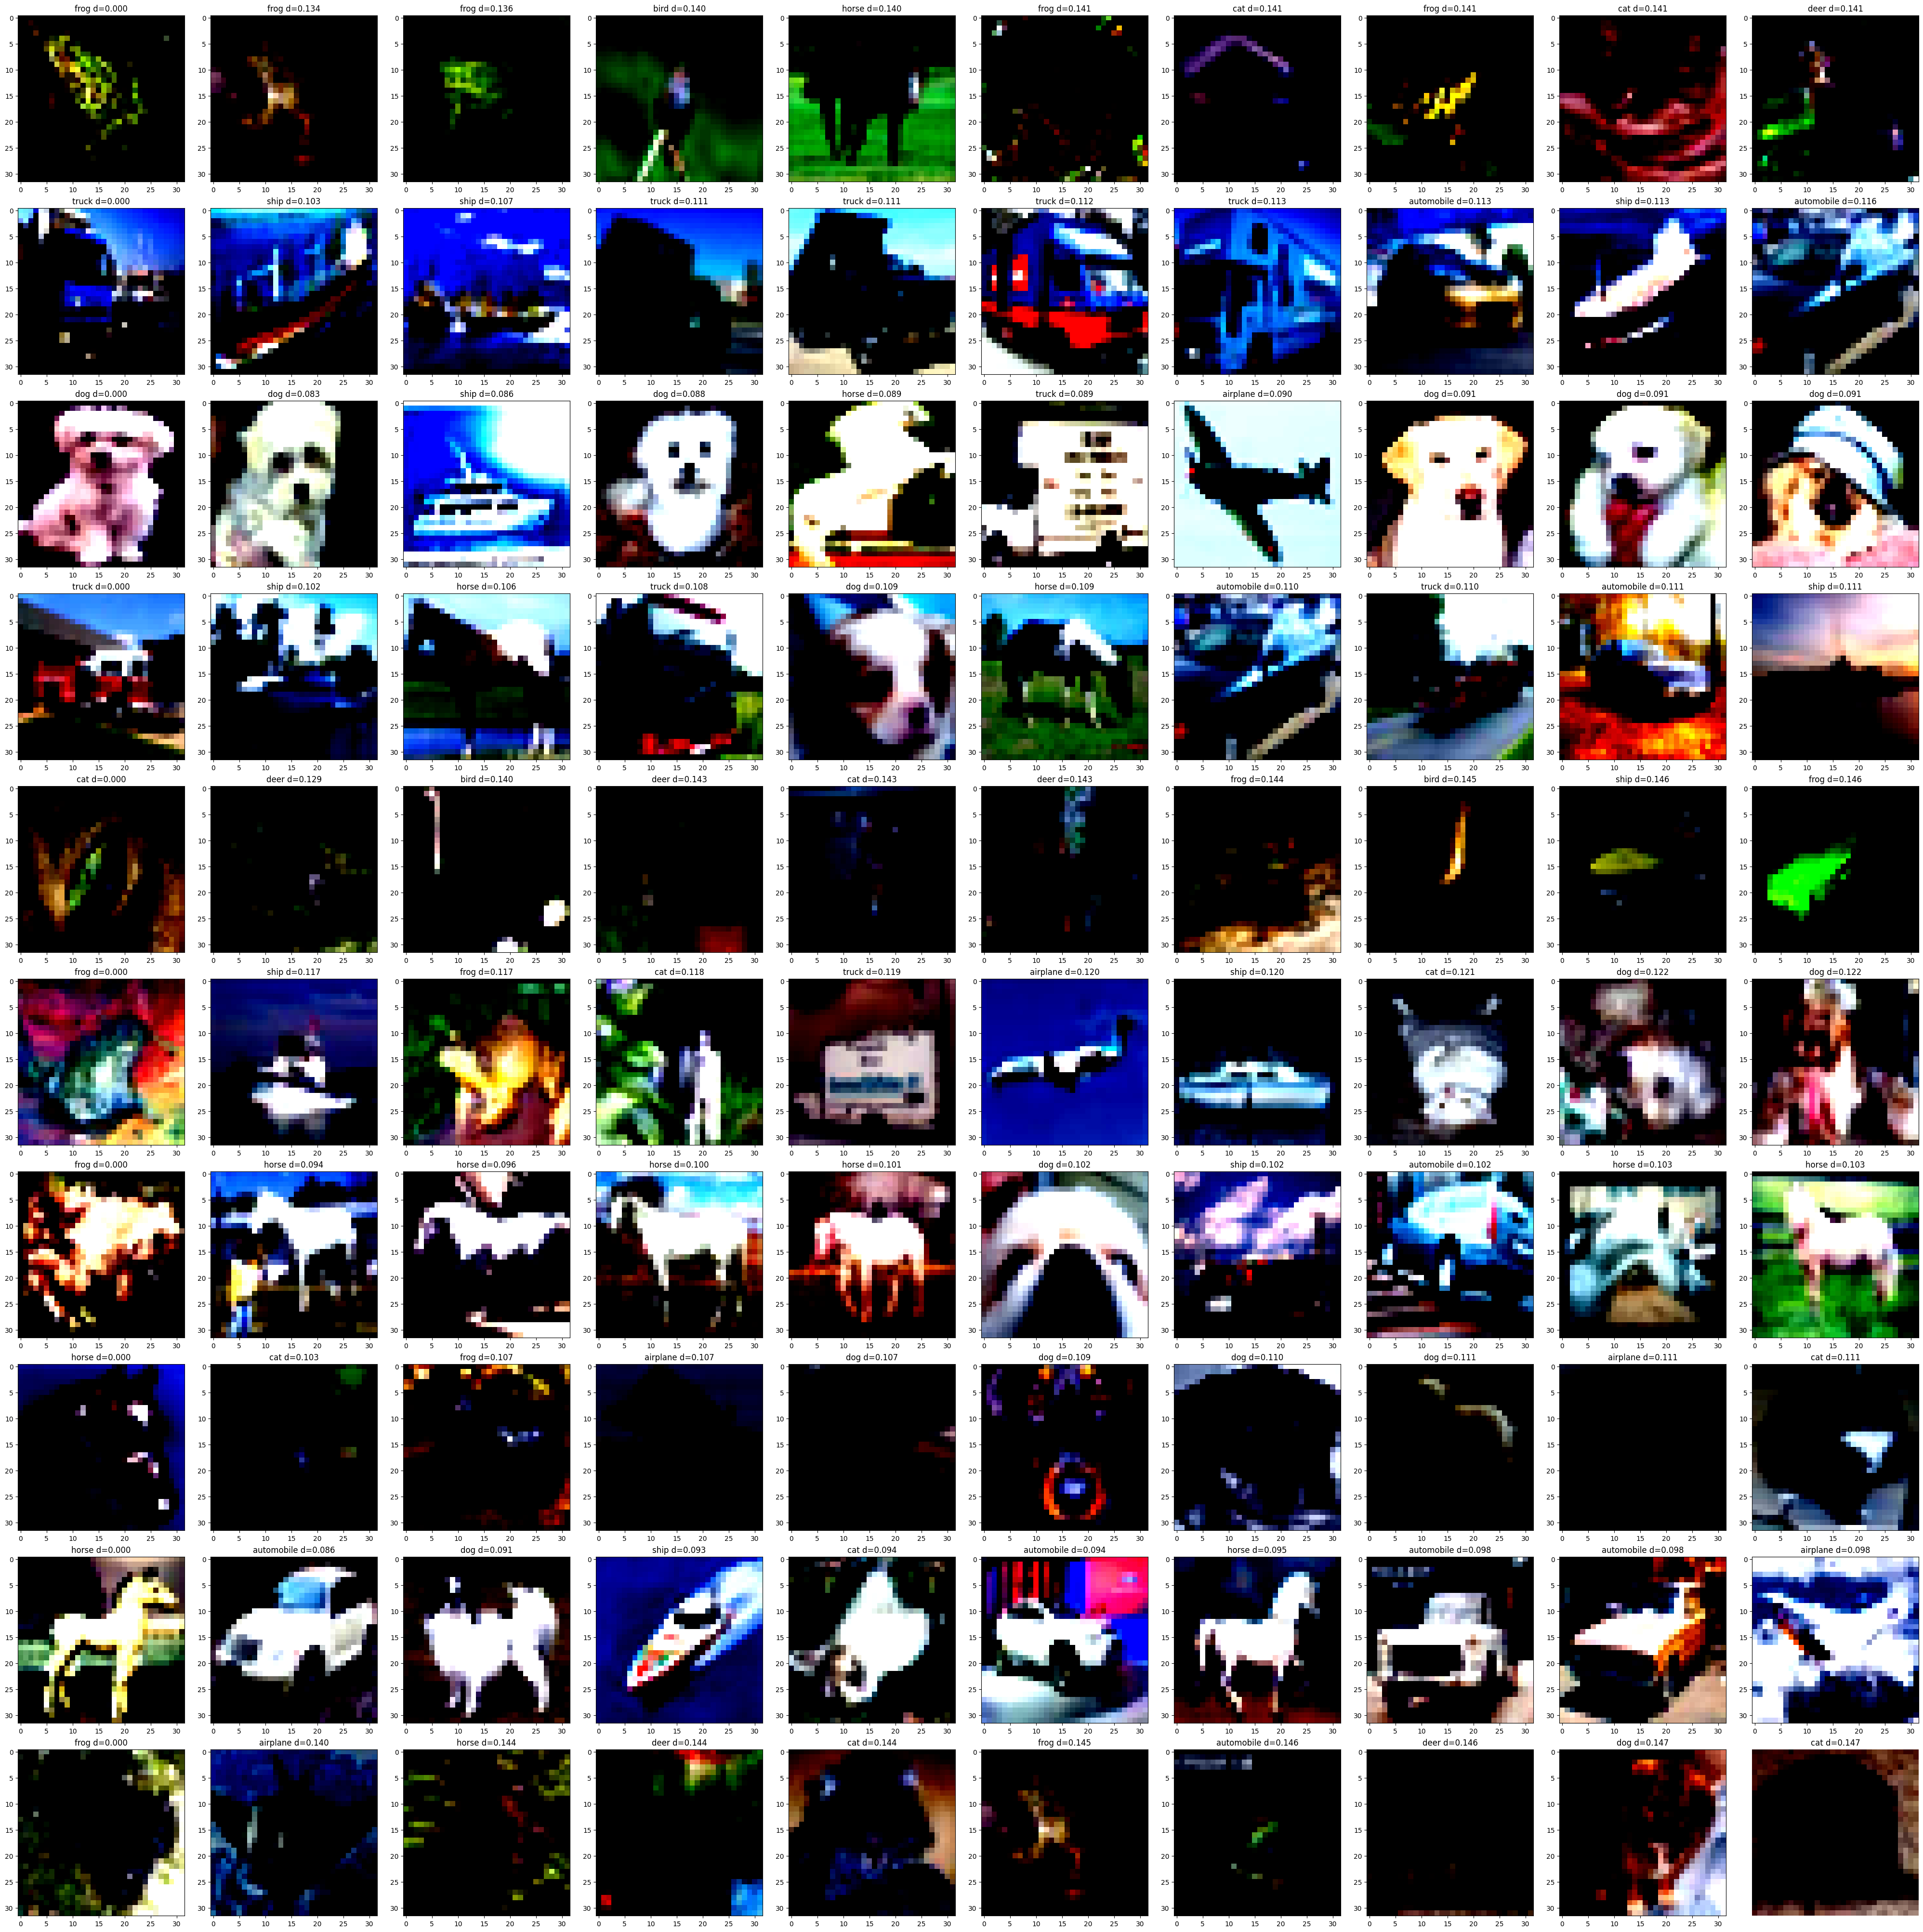

In [68]:
plot_knn_examples(embeddings, filenames, labels, num_examples=10, n_neighbors=10)

In [69]:
torch.save(backbone.state_dict(), 'model_cifar_10_byol.pt')

<a href="model_cifar_10(acc25).pt"> Download File </a>